In [4]:
# https://coderzcolumn.com/tutorials/artificial-intelligence/object-detection-using-pre-trained-pytorch-models

# Todo

How to speed up
* See if runs on CUDA
* Better GPU?

Have search pixels do random replacements
* Will this actually be better?
* Add all pixels to queue and shuffle it?

Implement binary / chunk search
* Starts with chunks as big as 100% of image
* Then half height and test all
* Then half width and test all
* Etc

Run random pixels and actual image in parrallel
* Do both at same time?
* Just to see difference

# Get Needed Packages

In [5]:
!pip install torch
!pip install pycocotools

import torch
import random
import pycocotools
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.functional import pil_to_tensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

print("TorchVision Version : {}".format(torchvision.__version__))
print("PyTorch Version : {}".format(torch.__version__))

C:\ProgramData\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


TorchVision Version : 0.14.1+cpu
PyTorch Version : 1.13.1+cpu


# Image Classification Function

## Constants from "get_image_data()" to speed it up

In [6]:
# The actual detection model
object_detection_model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
object_detection_model.eval(); ## Setting Model for Evaluation/Prediction

# File with the possible results
annFile='annotations/instances_val2017.json'
coco=COCO(annFile)    

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=1.01s)
creating index...
index created!


In [7]:
# Get the results of the image classification
def get_image_data(path):
    image = Image.open(path)
    image_tensor_int = pil_to_tensor(image)
    image_tensor_int = image_tensor_int.unsqueeze(dim=0)
    image_tensor_float = image_tensor_int / 255.0
    image_preds = object_detection_model(image_tensor_float)
    
    image_preds[0]["boxes"] = image_preds[0]["boxes"][image_preds[0]["scores"] > 0.8]
    image_preds[0]["labels"] = image_preds[0]["labels"][image_preds[0]["scores"] > 0.8]
    image_preds[0]["scores"] = image_preds[0]["scores"][image_preds[0]["scores"] > 0.8]
    
    image_labels = coco.loadCats(image_preds[0]["labels"].numpy())
    
    image_annot_labels = ["{}-{:.2f}".format(label["name"], prob) for label, prob in zip(image_labels, image_preds[0]["scores"].detach().numpy())]
        
    return [image_labels[0]["name"], image_preds[0]["scores"][0].item()]

# Auxiliary Functions

In [8]:
# Change a random pixel of an image to a random color
def change_random_pixel(path):
    image = Image.open(path)
    pixels = image.load()

    width, height = image.size
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    pixels[random.randint(0, width-1), random.randint(0, height-1)] = color
    image.save(path)

In [9]:
# Change a random pixel and analyze the result
def change_and_analyze(path):
    change_random_pixel(path)
    results = get_image_data(path)
    return get_image_data(path)

In [10]:
# Change a set pixel to a random color
def change_pixel_to_random_color(path, pixel_x, pixel_y):
    image = Image.open(path)
    pixels = image.load()

    width, height = image.size
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    pixels[pixel_x, pixel_y] = color
    image.save(path)

In [11]:
# Change a set pixel to the color of another image
def change_pixel_to_image(path, replacement_path, pixel_x, pixel_y):
    image = Image.open(path)
    pixels = image.load()
    
    replacement_image = Image.open(replacement_path)
    replacement_pixels = replacement_image.load()

    width, height = image.size
    
    pixels[pixel_x, pixel_y] = replacement_pixels[pixel_x, pixel_y]
    image.save(path)

In [12]:
# Clone the paths
def clone_path(base_path, clone_path):
    image = Image.open(base_path)
    image.save(clone_path)

# Get Initial Results

## Inputs

In [13]:
# Path of the original image
path = "dog.jpg"

# Path of the image to replace, leave as empty string if you want random pixels
replacement_path = ""

# How much you want the accuracy of the image classification to drop
acceptable_accuracy_drop = 0.10

In [14]:
# Deal with original image
path_2 = f"{2}_{path[:-4]}.png"
    
clone_path(path, path_2)

image = Image.open(path)
pixels = image.load()
width, height = image.size
print(width, height)

256 256


In [15]:
# Deal with replacement image
replacement_path_2 = ""

if replacement_path != "":
    replacement_path_2 = f"{2}_{replacement_path[:-4]}.png"
    img = Image.open(replacement_path)
    img_resize = img.resize((width, height), Image.LANCZOS)
    img_resize.save(replacement_path_2)
    print(replacement_path_2)

In [16]:
# Get starting variables
base_result_percentage = round(get_image_data(path_2)[1],5)
changes_list = []
accuracy_list = []
results = []
changes = 0

In [ ]:
# Iterate over image while changing pixels
for x in range(width):
    for y in range(height):
        
        # Setup temp image
        temp_path = f"{3}_{path[:-4]}.png"
        clone_path(path_2, temp_path)
        changes_list.append(changes)
        
        # Change pixels based on random pixels or image
        if replacement_path != "":
            change_pixel_to_image(temp_path, replacement_path_2, pixel_x, pixel_y)
        else:
            change_pixel_to_random_color(temp_path, x, y)
        
        # Result of the changes
        temp_result_percentage = round(get_image_data(path_2)[1],5)
        
        # Print out the information
        print("X: {}\tY: {}\tChanges: {}\tBase: {}\tTemp: {}\tDelta {}".format(
            x, y,
            changes,
            base_result_percentage,
            temp_result_percentage,
            round(abs(temp_result_percentage - base_result_percentage),5)
        ))
        
        # Check error bounds on image
        if temp_result_percentage >= (base_result_percentage-((acceptable_accuracy_drop*x*y)/(width*height))):
            # If within error bounds, keep the image
            clone_path(temp_path, path_2)
            changes += 1
        else:
            # Discard image
            clone_path(path_2, temp_path)
        
        # Update results
        results.append(changes)
        accuracy_list.append(temp_result_percentage)

# Results

## Plot Results

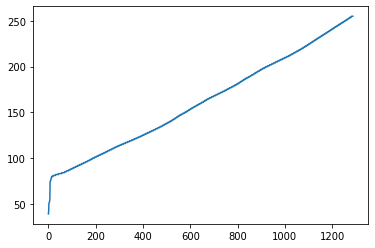

In [12]:
results_x = [i for i in range(len(results))]

plt.plot(results_x, results)
plt.show()

In [ ]:
accuracy_list_x = [i for i in range(len(accuracy_list))]

plt.plot(accuracy_list_x, accuracy_list)
plt.show()

## Show Results

In [13]:
# Original Image
original = Image.open(path)
original.show()

In [14]:
# Finished Image
finished = Image.open(path_2)
finished.show()